In [1]:
# Lab 3: Big Data analysis
# Introduction to Data Science (IT4930, IT4142E)
# School of Information and Communication Technology
# Hanoi University of Science and Technology

# Bài thực hành 3 (Practice Session 3)

## Vấn đề (Problems)
_Phân tích dữ liệu Yellow NYC Taxi 2025-07 để tìm ra giờ cao điểm di chuyển trong ngày/ khu vực có nhiều khách nhất._ (Analyze Yellow_NYC_Taxi_2025_07 dataset to find rush hours/ top customers zones)

_Dự đoán giá cước Taxi bằng Machine Learning._ (Predict fare_amount using Machine Learning)

## Thông tin dữ liệu (Dataset)

- Số lượng mẫu (Datapoints) : 3,898,963 bản ghi (records),  265 khu vực (265 zones).
- Số lượng thuộc tính (features)(20) :
     VendorID (mã định danh) , tpep_pickup_datetime (giờ đón khách) , tpep_dropoff_datetime (giờ trả khách) , passenger_count (số lượng khách) , trip_distance (khoảng cách) , RatecodeID (mã giá) , store_and_fwd_flag (cờ lưu chuyến đi) , PULocationID (mã khu vực đón khách) , DOLocationID (mã khu vực trả khách) , payment_type (loại thanh toán) , fare_amount (phí đi xe) , extra (phụ thu) , mta_tax (thuế theo meters) , tip_amount (tiền tip), tolls_amount (lệ phí khác) , improvement_surcharge (thuế phụ thu) , total_amount (tổng tiền) , congestion_surcharge (phí tắc nghẽn) , Airport_fee (phí sân bay) , cbd_congestion_fee (phí vận chuyển tắc nghẽn) .

## Mục tiêu (Goal)
1. Phân tích tập dữ liệu và thực hành một số EDA cơ bản. (Analyze the dataset and practice some basic EDAs)
2. Dự đoán fare_amount (Predict fare_amount)


Xem thêm thông tin về nguồn dữ liệu tại (Find out more about the datasets): (https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), (https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)


# Các bước tiến hành (Steps)



## Thư viện sử dụng (Libraries)
- pyspark : hỗ trợ xử lý và phân tích dữ liệu lớn theo mô hình phân tán, cung cấp các API để thao tác với DataFrame và MLLib cho Machine Learning.
- seaborn : thư viện trực quan hóa dữ liệu dựa trên matplotlib.
- matplotlib: phục vụ vẽ các đồ thị 2D trong Python
- plotly : thư viên trực quan hóa dữ liệu tương tác, cho phép vẽ biểu đồ động.
- scikit-learn (sklearn) : thư viện hỗ trợ xây dựng các mô hình học máy, các hàm training và testing.
- numpy: tính toán các phép biến đổi trên ma trận / vector
- pandas: phục vụ chuyển đổi trên dữ liệu dạng bảng


In [1]:
# Install deps
%pip install -q pyspark==3.5.1 seaborn matplotlib plotly scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries (import các thư viện cần thiết)
import os
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    VectorAssembler, StandardScaler, StringIndexer,
    OneHotEncoder, MinMaxScaler
)
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Set up plotting style (định dạng biểu đồ)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Load các tập dữ liệu từ Google Drive (Load the datasets from Google Drive - required students to pre-upload it)

Dữ liệu về chuyến đi taxi (taxi data : yellow_tripdata_2025-07.parquet) và các khu vực tại New York City (zone data : taxi_zone_lookup.csv)




In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# PROJECT_DIR = "/content/drive/MyDrive/BTL_KHDL/Thực hành KHDL/Buổi 3"
DATA_PATH = f"yellow_tripdata_2025-07.parquet"
ZONES_PATH = f"taxi_zone_lookup.csv"

In [6]:
import os

In [7]:
os.getcwd()

'd:\\Program Files\\VSCode\\DS_project\\homework\\session_3'

## Spark Session
- Khởi tạo Spark Session với thiết lập tối ưu (Initialize Spark session)

In [8]:
# Initialize Spark session with optimized configuration
spark = SparkSession.builder \
    .appName("NYC_Taxi_Analysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Set log level to reduce verbosity
spark.sparkContext.setLogLevel("WARN")

print("Spark session created successfully!")
print(f"Spark version: {spark.version}")
print(f"Python version: {sys.version}")

Spark session created successfully!
Spark version: 3.5.1
Python version: 3.13.7 | packaged by Anaconda, Inc. | (main, Sep  9 2025, 19:54:37) [MSC v.1929 64 bit (AMD64)]


## Đọc dữ liệu (Read the datasets)
- Đọc dữ liệu sử dụng pyspark.read (Read the datasets using pyspark.read function)

In [9]:
# Load taxi data (đọc dữ liệu taxi)
df = spark.read.parquet(DATA_PATH)
print(f"Loaded taxi data: {df.count():,} records")

# Load zones data (đọc dữ liệu khu vực)
zones = spark.read.csv(ZONES_PATH, header=True, inferSchema=True)
print(f"Loaded zones data: {zones.count()} zones")

# Show taxi data schema (lược đồ tập dữ liệu)
print("\nTaxi Data Schema:")
df.printSchema()

# Show sample data (xem thử vài mẫu dữ liệu)
print("\nSample Data:")
df.show(5, truncate=False)

Loaded taxi data: 3,898,963 records
Loaded zones data: 265 zones

Taxi Data Schema:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable 

In [10]:
print(type(zones))

<class 'pyspark.sql.dataframe.DataFrame'>


## Tiền xử lý dữ liệu (Data preprocessing)

### DEMO + PRACTICE: Data Preprocessing / Tiền xử lý dữ liệu
- Loại bỏ ngoại lệ, xử lý giá trị thiếu, giữ các cột quan trọng.
- ( Filter outliers, handle missing values, keep essential columns.)



## Kiểm tra tập dữ liệu trước khi tiền xử lý (Precheck the datasets before preprocessing)

- Kiểm tra số mẫu dữ liệu bị thiếu giá trị trong các cột thuộc tính quan trọng (Examine null examples in important columns)
- Kiểm tra phân phối của cột mục tiêu : fare_amount (Examine the target column distribution)

In [11]:
# Check initial data quality
print("Initial Data Quality:")
print(f"Total records: {df.count():,}")

# Check missing values in important columns
important_cols = ["passenger_count", "trip_distance", "PULocationID",
                 "DOLocationID", "fare_amount", "tpep_pickup_datetime"]

print("\nMissing values in important columns:")
for col_name in important_cols:
    null_count = df.filter(col(col_name).isNull()).count()
    print(f"{col_name}: {null_count:,} missing values")

# Check fare amount distribution
print("\nFare amount statistics:")
df.select("fare_amount").describe().show()



Initial Data Quality:
Total records: 3,898,963

Missing values in important columns:
passenger_count: 1,038,755 missing values
trip_distance: 0 missing values
PULocationID: 0 missing values
DOLocationID: 0 missing values
fare_amount: 0 missing values
tpep_pickup_datetime: 0 missing values

Fare amount statistics:
+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|           3898963|
|   mean|18.547692047860266|
| stddev|20.071383594139693|
|    min|           -1591.3|
|    max|            2495.0|
+-------+------------------+



# Làm sạch dữ liệu (Data Cleaning)
Lưu ý:
- Chỉ giữ các giá trị `fare_amount` < 200 and `trip_distance` < 100. (Only keep 0 < "fare_amount" values < 200 and 0 < "trip_distance" < 100)
- Điền trung vị cho `passenger_count`. (fill passenger_count with median)

## Demo 1: Loại bỏ các mẫu dữ liệu chứa giá trị null (Dropping null values in columns)

In [12]:
# Cleaning Step 1: Drop nulls in important columns
print("Cleaning data...")
print("Step 1: Dropping nulls in important columns...")
df_no_nulls = df.na.drop(subset=important_cols)
print(f"Remaining after dropna: {df_no_nulls.count():,} records")


Cleaning data...
Step 1: Dropping nulls in important columns...
Remaining after dropna: 2,860,208 records


## Practice 1  : Loại bỏ các mẫu dữ liệu fare_amounts không hợp lí (Removing non-realism fare_amounts examples)

In [13]:
##### Practice 1 ##### (Step 2)
# Yêu cầu: Loại bỏ các mẫu dữ liệu có fare_amount < 0 hoặc > 200 (Only keep 0 < "fare_amount" values < 200 )
# Gợi ý: df.filter - xem hướng dẫn tại : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.filter.html
######################
print("Step 2: Filtering reasonable fare_amounts (0 < fare < 200)...")
df_fare_filtered = df_no_nulls.filter(
    (df_no_nulls['fare_amount'] > 0) & (df_no_nulls['fare_amount'] < 200)
)

print(f"Remaining after fare filter: {df_fare_filtered.count():,} records")


Step 2: Filtering reasonable fare_amounts (0 < fare < 200)...
Remaining after fare filter: 2,780,802 records


## Practice 2 : Loại bỏ các mẫu dữ liệu trip_distance không hợp lí (Removing non-realism trip_distance examples)

In [14]:
##### Practice 2 ##### (Step 3)
# Yêu cầu: Loại bỏ các mẫu dữ liệu có trip_distance < 0 hoặc > 100 (Only keep 0 < "trip_distance" < 100)
# Gợi ý: df.filter _ xem hướng dẫn tại : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.filter.html
######################
print("Step 3: Filtering reasonable trip distances (0 < miles < 100)...")
df_clean = df_fare_filtered.filter(
    (df_fare_filtered['trip_distance'] > 0) & (df_fare_filtered['trip_distance'] < 100)
)

print(f"Remaining after trip_distance filter: {df_clean.count():,} records")

Step 3: Filtering reasonable trip distances (0 < miles < 100)...
Remaining after trip_distance filter: 2,746,747 records


## Kiểm tra quá trình tiền xử lý dữ liệu (Verify the preprocessing process)

In [15]:
# Fill passenger_count with median
median_passenger = df_clean.approxQuantile("passenger_count", [0.5], 0.01)[0]
df_clean = df_clean.na.fill({"passenger_count": median_passenger})

print(f"Cleaned data: {df_clean.count():,} records")
print(f"Data reduction so far: {((df.count() - df_clean.count()) / df.count() * 100):.1f}%")
print(f"Median passenger_count: {median_passenger}")


# Cleaning Step 4: Final verification of missing values
print("\nMissing values after cleaning:")
for col_name in important_cols:
    null_count = df_clean.filter(col(col_name).isNull()).count()
    print(f"{col_name}: {null_count} missing values")


Cleaned data: 2,746,747 records
Data reduction so far: 29.6%
Median passenger_count: 1.0

Missing values after cleaning:
passenger_count: 0 missing values
trip_distance: 0 missing values
PULocationID: 0 missing values
DOLocationID: 0 missing values
fare_amount: 0 missing values
tpep_pickup_datetime: 0 missing values


# Exploratory Data Analysis (Khám phá dữ liệu)

In [16]:
# Basic statistics (Kiểm tra các thuộc tính quan trọng)
print("Basic Statistics:")
df_clean.select("fare_amount", "trip_distance", "passenger_count").describe().show()

Basic Statistics:
+-------+------------------+-----------------+------------------+
|summary|       fare_amount|    trip_distance|   passenger_count|
+-------+------------------+-----------------+------------------+
|  count|           2746747|          2746747|           2746747|
|   mean|19.820712264363117|3.495520847023779|1.3108036524659898|
| stddev|17.954776779018985|4.544554478947052|0.7532452170725301|
|    min|              0.01|             0.01|                 0|
|    max|            199.99|            98.39|                 9|
+-------+------------------+-----------------+------------------+



In [17]:
# Dùng df_samples = 50% data để minh họa
if 'df_sample' not in globals():
    sample_size = 0.50  # Có thể tự điều chỉnh % data minh họa (modifiable)
    df_sample = df_clean.sample(False, sample_size, seed=42)
    print(f"Using {sample_size*100}% sample for visualization: {df_sample.count():,} records")

Using 50.0% sample for visualization: 1,374,934 records


# Demo 2 : Phân tích phân phối của fare_amounts (Examine fare_amounts distribution)
- histogram : Biểu đồ tần suất


Fare Distribution Analysis:


c:\Users\DELL\.conda\envs\practice_DS\Lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


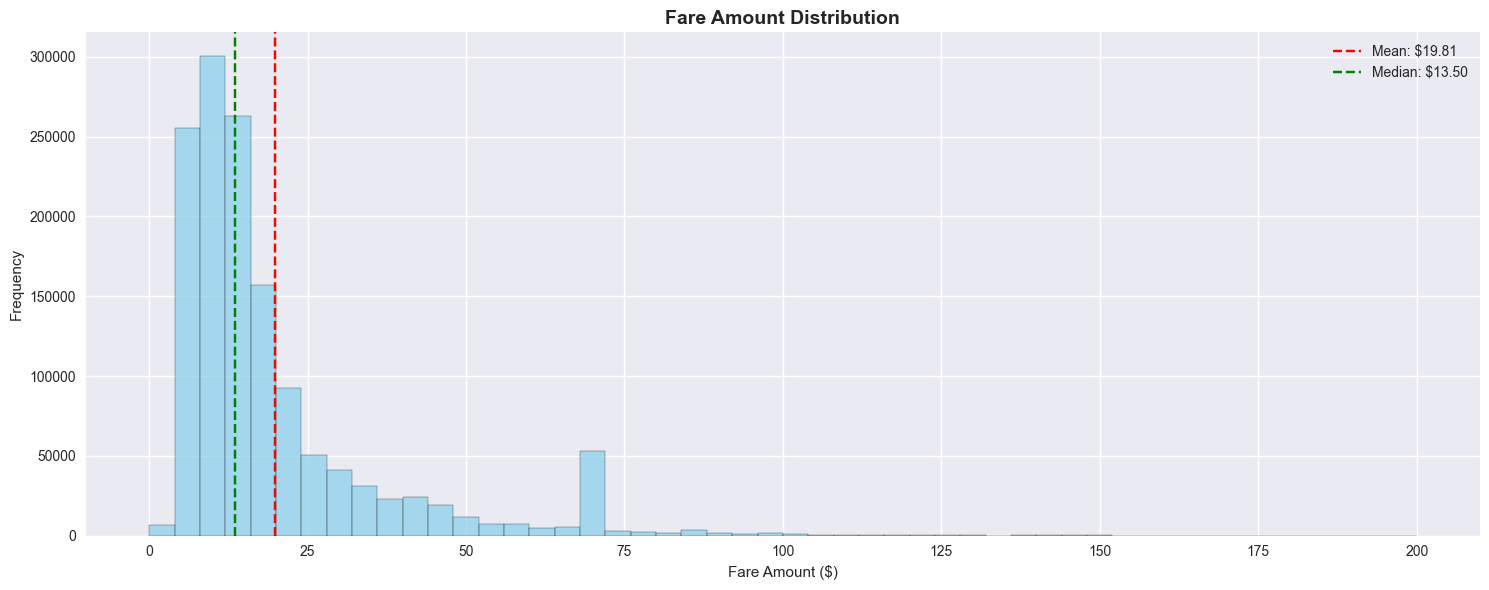

Fare Statistics:
Mean: $19.81
Median: $13.50
Std: $17.94
Min: $0.01
Max: $199.99


In [18]:
print("Fare Distribution Analysis:")

# Convert sample to pandas for visualization (keep just what's needed)
fare_sample = df_sample.select("fare_amount").toPandas()

# Single plot: histogram of fare_amount
fig, ax = plt.subplots(figsize=(15, 6))
ax.hist(fare_sample["fare_amount"], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax.set_title("Fare Amount Distribution", fontsize=14, fontweight='bold')
ax.set_xlabel("Fare Amount ($)")
ax.set_ylabel("Frequency")

# Add mean/median lines
ax.axvline(fare_sample["fare_amount"].mean(), color='red', linestyle='--',
           label=f"Mean: ${fare_sample['fare_amount'].mean():.2f}")
ax.axvline(fare_sample["fare_amount"].median(), color='green', linestyle='--',
           label=f"Median: ${fare_sample['fare_amount'].median():.2f}")
ax.legend()

plt.tight_layout()
plt.show()

# Print statistics
print("Fare Statistics:")
print(f"Mean: ${fare_sample['fare_amount'].mean():.2f}")
print(f"Median: ${fare_sample['fare_amount'].median():.2f}")
print(f"Std: ${fare_sample['fare_amount'].std():.2f}")
print(f"Min: ${fare_sample['fare_amount'].min():.2f}")
print(f"Max: ${fare_sample['fare_amount'].max():.2f}")

# Demo 3 : Phân tích phân phối trip_distance (Examine trip_distance distribution)
Calculate :
- mean
- median
- correlation with fare_amount

Trip Distance Analysis:


c:\Users\DELL\.conda\envs\practice_DS\Lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


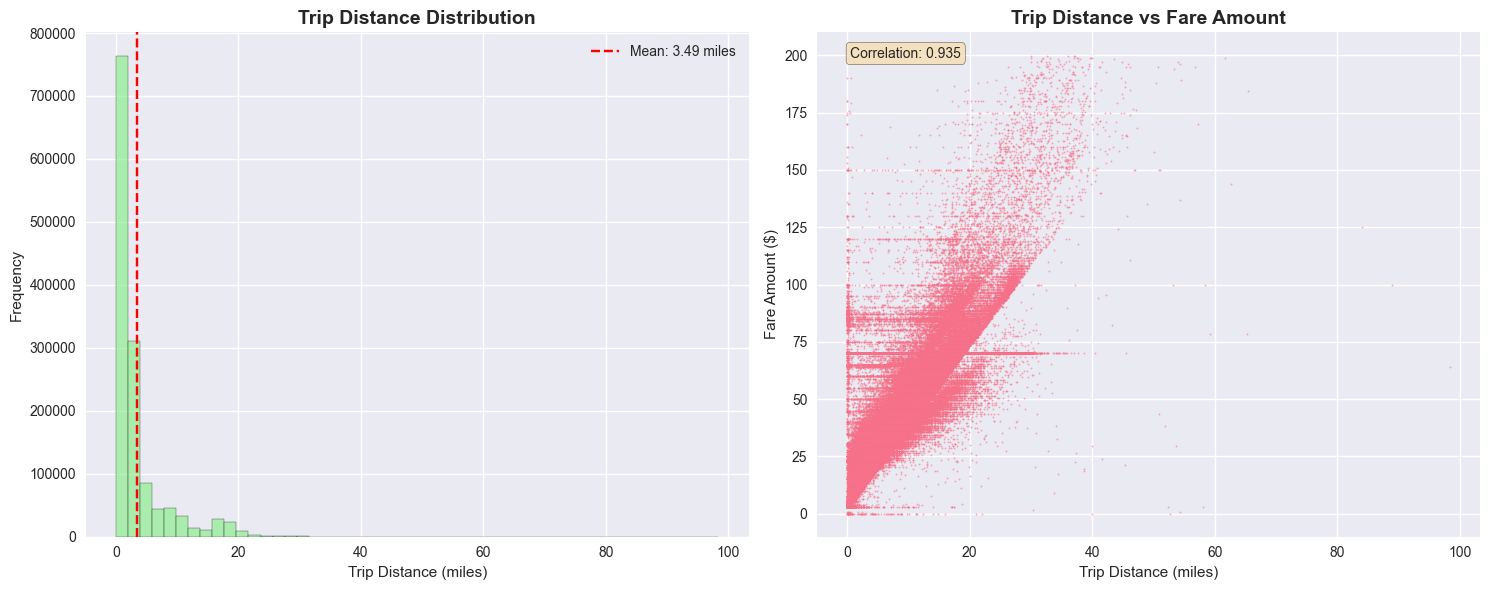

Distance Statistics:
Mean: 3.49 miles
Median: 1.75 miles
Correlation with fare: 0.935


In [19]:
# 4.2 Trip Distance Analysis
print("Trip Distance Analysis:")

# Convert sample to pandas for visualization
distance_sample = df_sample.select("trip_distance", "fare_amount").toPandas()

# Create distance analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distance histogram
ax1.hist(distance_sample["trip_distance"], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax1.set_title("Trip Distance Distribution", fontsize=14, fontweight='bold')
ax1.set_xlabel("Trip Distance (miles)")
ax1.set_ylabel("Frequency")
ax1.axvline(distance_sample["trip_distance"].mean(), color='red', linestyle='--',
           label=f'Mean: {distance_sample["trip_distance"].mean():.2f} miles')
ax1.legend()

# Distance vs Fare scatter
ax2.scatter(distance_sample["trip_distance"], distance_sample["fare_amount"],
           alpha=0.5, s=1)
ax2.set_title("Trip Distance vs Fare Amount", fontsize=14, fontweight='bold')
ax2.set_xlabel("Trip Distance (miles)")
ax2.set_ylabel("Fare Amount ($)")

# Add correlation
correlation = distance_sample["trip_distance"].corr(distance_sample["fare_amount"])
ax2.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax2.transAxes,
        bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Distance Statistics:")
print(f"Mean: {distance_sample['trip_distance'].mean():.2f} miles")
print(f"Median: {distance_sample['trip_distance'].median():.2f} miles")
print(f"Correlation with fare: {correlation:.3f}")



# Practice 3 : Phân tích dữ liệu để tìm ra giờ cao điểm di chuyển Taxi trong ngày (Analyze data to find rush hours)

## Guide
- Dùng df.withColumn và df.groupBy : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html


Rush Hour Analysis:
Top 5 busiest hours:
+----+------+
|hour| count|
+----+------+
|  18|196988|
|  17|191101|
|  16|177623|
|  19|175314|
|  15|175248|
+----+------+
only showing top 5 rows



c:\Users\DELL\.conda\envs\practice_DS\Lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
C:\Users\DELL\AppData\Local\Temp\ipykernel_16452\1049048894.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_pdf, x="hour", y="count", ax=ax1, palette="viridis")


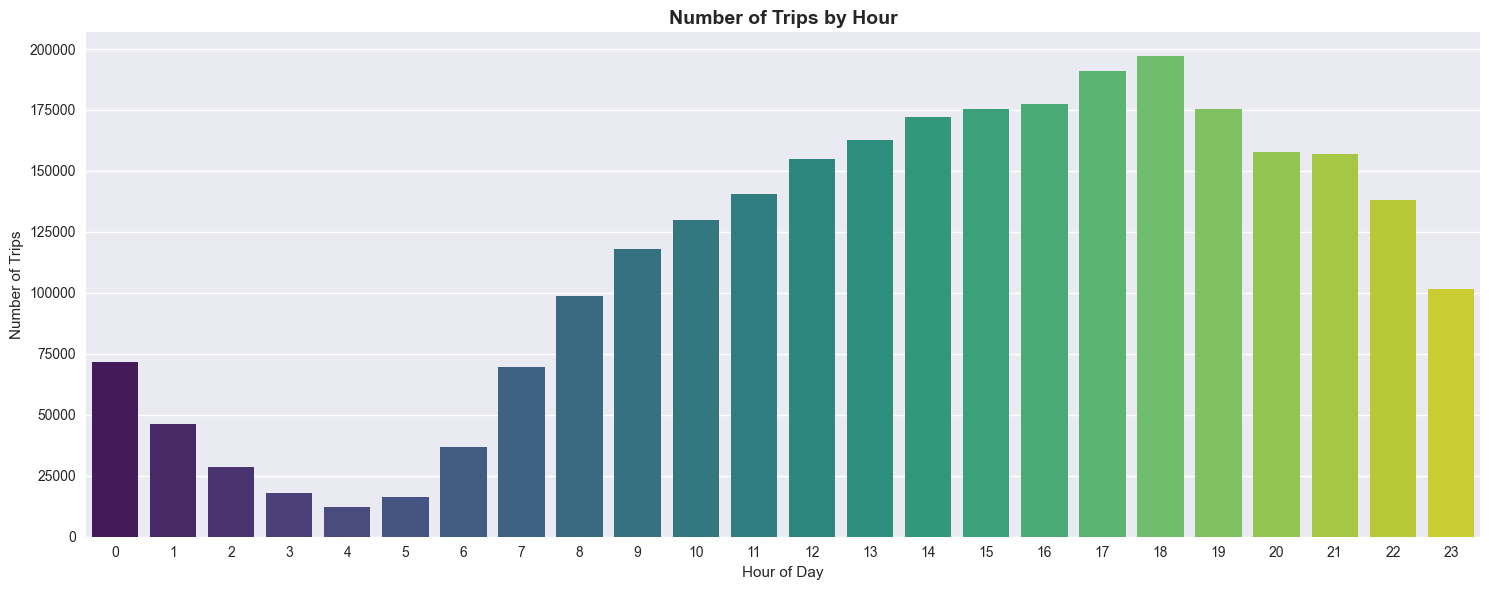

In [20]:
#### Practice 3 – Rush Hour Analysis ####
print("Rush Hour Analysis:")

# Step 1 - Feature engineering : extract hour-of-day from pickup time
# Bước 1 - Trích xuất giờ trong ngày từ thời điểm đón khách
df_with_hour = df_clean.withColumn("hour", hour("tpep_pickup_datetime"))

# Step 2 - Aggregate: trips per hour
# Bước 2 - Tổng hợp: đếm số chuyến theo từng giờ
hourly_trips = (
        df_with_hour.groupBy("hour") # group by discrete hour 0..23 / nhóm theo giờ 0..23
        .count() # count trips in each hour / đếm số chuyến trong mỗi giờ
        .orderBy("count", ascending=False) # sort busiest first / sắp xếp giảm dần
)

print("Top 5 busiest hours:")
hourly_trips.show(5)

# Step 3 - Plot
# Bước 3 - Vẽ biểu đồ
hourly_pdf = hourly_trips.orderBy("hour").toPandas()  # order by hour for nicer x-axis
fig, ax1 = plt.subplots(1, figsize=(15, 6))
sns.barplot(data=hourly_pdf, x="hour", y="count", ax=ax1, palette="viridis")
ax1.set_title("Number of Trips by Hour", fontsize=14, fontweight='bold')
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Number of Trips")
ax1.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

# Practice 4 : Phân tích dữ liệu để tìm ra khu vực có nhiều khách nhất (Analyze data to find top customers zones)

Guide
- Sử dụng các hàm giống Exercise 4.3 (groupby, ...)
- Cần thêm hàm join để nhóm PULocationID với tên tương ứng cho từng khu vực (Need "join" function to join PULocationID with the corresponding zones)

Top Pickup Zones Analysis:
Top 10 pickup zones:
+------------+------+---------+----------------------------+
|PULocationID|count |Borough  |Zone                        |
+------------+------+---------+----------------------------+
|132         |167920|Queens   |JFK Airport                 |
|161         |143447|Manhattan|Midtown Center              |
|237         |130210|Manhattan|Upper East Side South       |
|186         |114311|Manhattan|Penn Station/Madison Sq West|
|162         |107670|Manhattan|Midtown East                |
|236         |101924|Manhattan|Upper East Side North       |
|230         |98334 |Manhattan|Times Sq/Theatre District   |
|138         |95386 |Queens   |LaGuardia Airport           |
|170         |85965 |Manhattan|Murray Hill                 |
|142         |80945 |Manhattan|Lincoln Square East         |
+------------+------+---------+----------------------------+
only showing top 10 rows



c:\Users\DELL\.conda\envs\practice_DS\Lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


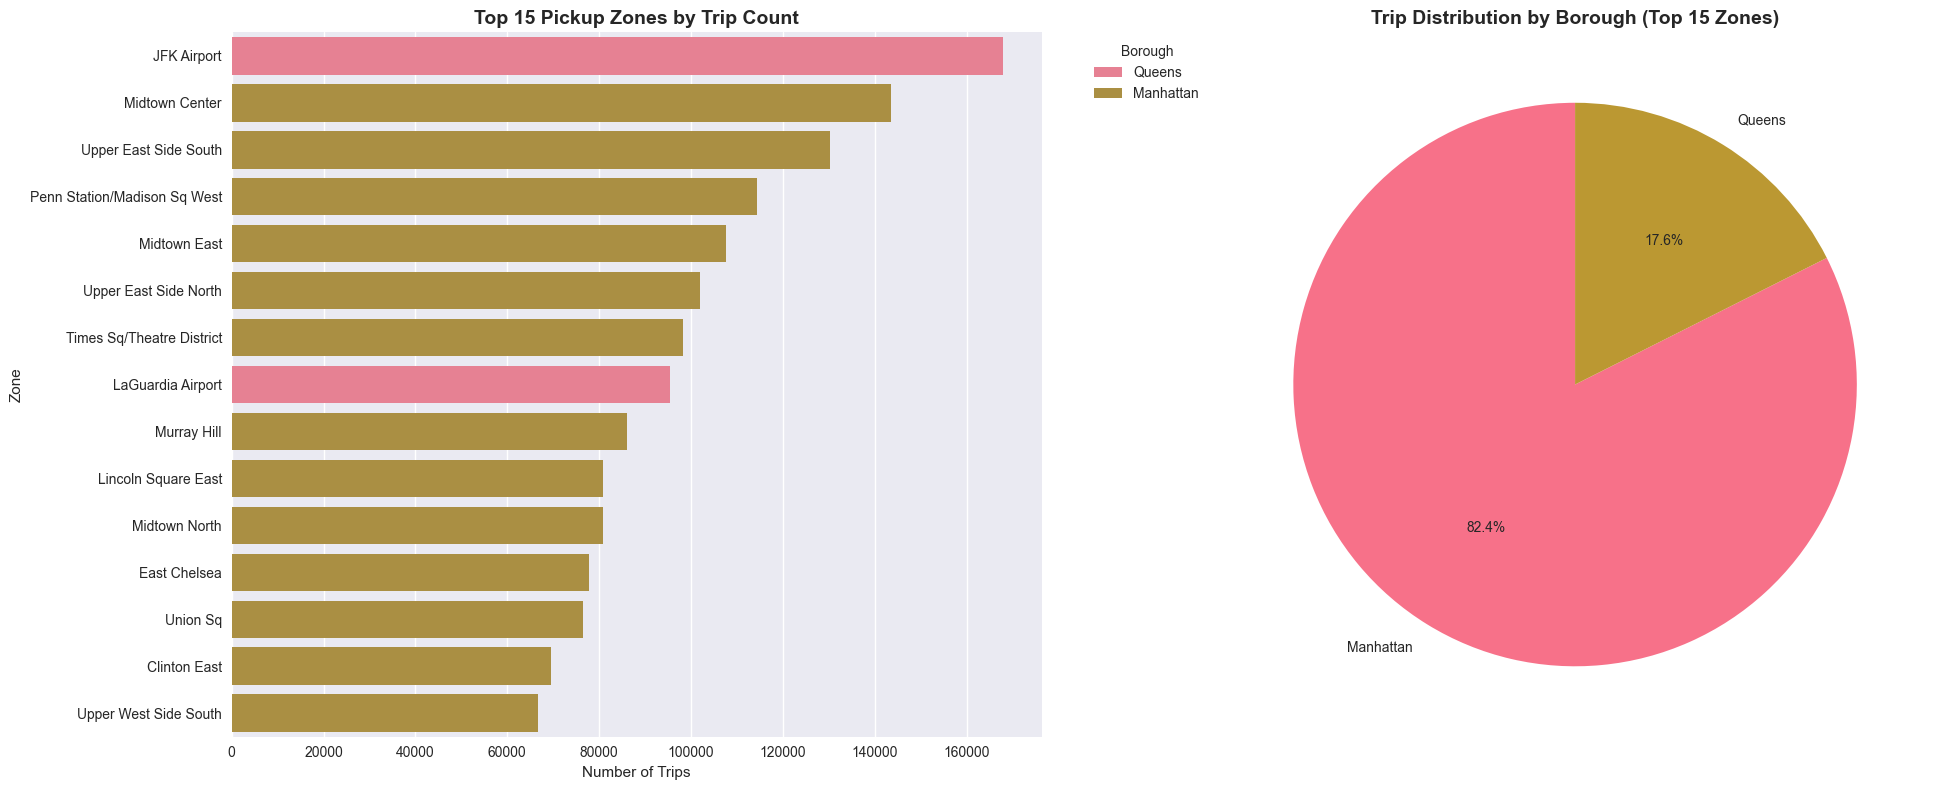

In [24]:
#### Practice 4 : Top Pickup Zones Analysis ####
print("Top Pickup Zones Analysis:")

# Get top pickup zones by PULocationID
top_zones = df_clean.groupBy("PULocationID").count()

# Join with zones data (#Nối tên khu vực từ bảng tra cứu lookup_zone)
top_zones_named = top_zones.join(
    zones,
    top_zones['PULocationID'] == zones['LocationID'],
    "left"
).select("PULocationID", "count", "Borough", "Zone").orderBy("count", ascending=False)

print("Top 10 pickup zones:")
top_zones_named.show(10, truncate=False)

# Convert to pandas for visualization
top_zones_pdf = top_zones_named.limit(15).toPandas()

# Create enhanced visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Horizontal bar plot
sns.barplot(data=top_zones_pdf, x="count", y="Zone", hue="Borough", ax=ax1, dodge=False)
ax1.set_title("Top 15 Pickup Zones by Trip Count", fontsize=14, fontweight='bold')
ax1.set_xlabel("Number of Trips")
ax1.legend(title="Borough", bbox_to_anchor=(1.05, 1), loc='upper left')

# Borough distribution
borough_counts = top_zones_pdf.groupby("Borough")["count"].sum().reset_index()
ax2.pie(borough_counts["count"], labels=borough_counts["Borough"], autopct='%1.1f%%', startangle=90)
ax2.set_title("Trip Distribution by Borough (Top 15 Zones)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Kết nối EDA với Machine Learning (Why EDA matters for ML)

- **Top Pickup Zones Analysis (PULocationID)**
  - Vì sao phân tích: nhận diện khu vực nhu cầu cao, phân phối mất cân bằng theo zone.
  - Liên hệ ML: quyết định mã hoá phân loại (`StringIndexer` + `OneHotEncoder`) cho `PULocationID`, `DOLocationID`.

- **Rush Hour Analysis (Giờ cao điểm)**
  - Vì sao phân tích: nhu cầu/giá cước biến thiên theo thời gian trong ngày/tuần.
  - Liên hệ ML: tạo đặc trưng thời gian `hour`, `day_of_week`, `is_weekend`.

- **Trip Distance Analysis (Khoảng cách di chuyển)**
  - Vì sao phân tích: quan hệ mạnh với `fare_amount`, phát hiện ngoại lệ/độ lệch.
  - Liên hệ ML: lọc dữ liệu không hợp lý (0 < distance < 100) giảm nhiễu; chuẩn hoá đặc trưng số (`StandardScaler`) giúp tối ưu tốt hơn.

- **Fare Amount Analysis (Phân phối mục tiêu)**
  - Vì sao phân tích: hiểu phân phối đích, kiểm tra lệch/skew và ngoại lệ.
  - Liên hệ ML: chọn và diễn giải metric phù hợp (dùng cả RMSE, MAE, R²).


- **Thiết kế Pipeline & Đánh giá**
  - Từ EDA → chọn bộ đặc trưng, mã hoá, chuẩn hoá, và cách chia dữ liệu (`randomSplit` trên `df_features` để tránh leakage).
  - Dùng nhiều chỉ số (RMSE, MAE, R²) để đánh giá toàn diện; so sánh kịch bản "Basic Features" vs "All Features" để định lượng giá trị của feature engineering.

> English summary: EDA guides feature choices, encoding/scaling strategy, data cleaning rules, metric selection, and experiment design. It turns raw domain patterns (zones, hours, distance, fare distribution) into concrete ML features and robust evaluation.



# Machine Learning Pipeline
Mục tiêu : Dự đoán giá cước fare_amounts bằng các mô hình học máy (Predict fare_amount using ML models)

## Kịch bản thực hành (Practice Scenarios)
- **Kịch bản 1**: Sử dụng đặc trưng cơ bản (Basic Features) - passenger_count, trip_distance, hour, day_of_week, is_weekend, PULocationID, DOLocationID
- **Kịch bản 2**: Sử dụng toàn bộ đặc trưng (All Features) - bao gồm tất cả các cột có thể sử dụng từ dataset

##  Hướng dẫn xây dựng Pipeline (Pipeline Building Guide)

### Bước 1: Feature Engineering (Kỹ thuật đặc trưng)
- Trích xuất đặc trưng thời gian từ datetime
- Tạo đặc trưng phân loại từ dữ liệu định danh
- Chuẩn hóa dữ liệu số

### Bước 2: Data Preprocessing (Tiền xử lý dữ liệu)
- StringIndexer: Chuyển đổi dữ liệu phân loại thành số
- OneHotEncoder: Tạo vector one-hot cho dữ liệu phân loại
- VectorAssembler: Gộp tất cả đặc trưng thành một vector
- StandardScaler: Chuẩn hóa dữ liệu về trung bình 0, độ lệch chuẩn 1

### Bước 3: Model Training (Huấn luyện mô hình)
- Chia dữ liệu train/test
- Huấn luyện mô hình với pipeline
- Đánh giá hiệu suất

### Bước 4: Model Evaluation (Đánh giá mô hình)
- Sử dụng phương pháp chia đôi (Hold-out)
- Tính toán các chỉ số RMSE, MAE, R²
- So sánh hiệu suất giữa các kịch bản

# Kịch bản 1: Đặc trưng cơ bản (Basic Features)

In [25]:
# Feature Engineering - Kịch bản 1: Đặc trưng cơ bản (Basic Features)
print("Feature Engineering : ")

# Add temporal features (Thêm các đặc trưng ngày - giờ )
# - hour: hour of day from pickup time (0–23)
#   -> đặc trưng theo giờ trong ngày, giúp nhận diện giờ cao điểm
# - day_of_week: Spark trả về 1..7 (1=Sunday, 7=Saturday)
#   -> ngày trong tuần, phân biệt ngày thường và cuối tuần
# - is_weekend: 1 nếu Chủ nhật hoặc Thứ bảy, ngược lại 0
#   -> cờ cuối tuần để mô hình học khác biệt hành vi đi lại
df_features = (
    df_clean
    .withColumn("hour", hour("tpep_pickup_datetime"))
    .withColumn("day_of_week", dayofweek("tpep_pickup_datetime"))
    .withColumn("is_weekend", when(col("day_of_week").isin([1, 7]), 1).otherwise(0))
)

# Quick peek (xem nhanh) các đặc trưng mới
print("Sample of engineered features:")
df_features.select(
    "hour", "day_of_week", "is_weekend",
    "passenger_count", "trip_distance", "fare_amount"
).show(5)

Feature Engineering : 
Sample of engineered features:
+----+-----------+----------+---------------+-------------+-----------+
|hour|day_of_week|is_weekend|passenger_count|trip_distance|fare_amount|
+----+-----------+----------+---------------+-------------+-----------+
|   0|          3|         0|              1|          7.3|       29.6|
|   0|          3|         0|              1|         17.7|       70.0|
|   0|          3|         0|              1|         9.98|       43.6|
|   0|          3|         0|              1|        10.27|       38.7|
|   0|          3|         0|              1|         2.94|       17.0|
+----+-----------+----------+---------------+-------------+-----------+
only showing top 5 rows



# Practice 5.1 : Build ML pipeline cho kịch bản 1 (First scenario ML pipeline)

In [26]:
##### Practice 5.1 Build ML Pipeline #####
print("Building ML Pipeline...")

# 1) Categorical encoding for IDs
# StringIndexer: map each ID -> integer index
# OneHotEncoder: convert index -> one-hot vector (tránh coi ID là số có thứ tự)
pu_indexer = StringIndexer(inputCol="PULocationID", outputCol="PULocationID_index", handleInvalid="keep")
do_indexer = StringIndexer(inputCol="DOLocationID", outputCol="DOLocationID_index", handleInvalid="keep")
encoder = OneHotEncoder(
    inputCols=["PULocationID_index", "DOLocationID_index"],
    outputCols=["PULocationID_vec", "DOLocationID_vec"]
)

# 2) Assemble all features into a single vector (gom các đặc trưng vào 1 vector)
feature_cols = [
    "passenger_count", "trip_distance",
    "hour", "day_of_week", "is_weekend", #Thêm các đặc trưng cần dùng (#Add the features you need to use)
    "PULocationID_vec", "DOLocationID_vec"
]
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

# 3) Scale features (chuẩn hóa các đặc trưng về trung bình = 0 , độ lệch chuẩn = 1)
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withMean=True,
    withStd=True
)

# 4) Model: Linear Regression (hồi quy tuyến tính) _ SV có thể tùy chỉnh Hyperparameter : maxIter, regParam, elasticNetParam
# - labelCol: target cột giá cước
# - featuresCol: dùng bản đã scale
lr = LinearRegression(
    featuresCol="scaled_features", #Thêm cột đặc trưng input cho model - Add features cols for the model
    labelCol="fare_amount",  #Thêm cột mục tiêu - add target column
    maxIter=100,
    regParam=0.1,
    elasticNetParam=0.5
)

# 5) Pipeline chain : Index -> Encode -> Assemble -> Scale -> Model
lr_pipeline = Pipeline(stages=[pu_indexer, do_indexer, encoder, assembler, scaler, lr])

print("Success")

Building ML Pipeline...
Success


# Practice 5.2 : Chia tập Train/Test và huấn luyện mô hình kịch bản 1 (Train/Test split and model training for first scenario)
Guide
-  randomSplit : https://www.geeksforgeeks.org/python/pyspark-randomsplit-and-sample-methods/

In [27]:
#### Practice 5.2 : Train-Test Split and Model Training ####
print("Splitting dataset...")

# Train-test split (df_features)
train_data, test_data = df_features.randomSplit([0.8, 0.2])  #Dùng hàm randomSplit
print(f"Training data: {train_data.count():,} records")
print(f"Test data: {test_data.count():,} records")

Splitting dataset...
Training data: 2,197,017 records
Test data: 549,730 records


# Practice 5.3 : Huấn luyện mô hình kịch bản 1 (Train the first scenario model)
Guide
- Dùng hàm fit cho pipeline đã xây dựng (pipeline.fit)

In [28]:
### Practice 5.3 : Huấn luyện mô hình ####
print("\n Training Linear Regression...")
lr_model = lr_pipeline.fit(train_data)
lr_predictions = lr_model.transform(test_data)

print("Model trained successfully!")


 Training Linear Regression...
Model trained successfully!


# Kịch bản 2 : Sử dụng toàn bộ đặc trưng (2nd Scenario : All features)

# Practice 6.1 : 2nd Scenario ML pipeline

In [29]:
# Practice 6.1 — Scenario 2: ALL original columns (except label)
# Yêu cầu : SV dựa vào kịch bản thứ 1 để xây dựng mô hình Linear Regression sử dụng tất cả các đặc trưng của tập dữ liệu (Based on the first scenario, build an all-feature Linear Regression model)

In [37]:
df_features.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+----+-----------+----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|hour|day_of_week|is_weekend|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+----+-----------+----------+
|       1| 2025-07-01 00:29:37|  2025-07-01 00

In [47]:
##### Practice 5.2 Build ML Pipeline #####
print("Building ML Pipeline...")

# 1) Categorical encoding for IDs
# StringIndexer: map each ID -> integer index
# OneHotEncoder: convert index -> one-hot vector (tránh coi ID là số có thứ tự)
categorical_cols = ["RatecodeID", "store_and_fwd_flag", "VendorID", "payment_type", "is_weekend", "PULocationID", "DOLocationID"]

indexer = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in categorical_cols
]

encoder = [
    OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec")
    for c in categorical_cols
]

# 2) Assemble all features into a single vector (gom các đặc trưng vào 1 vector)
feature_cols_all = [
    "passenger_count", "trip_distance", "hour", "day_of_week", "is_weekend",
    "extra", "mta_tax", "improvement_surcharge", "congestion_surcharge", "tolls_amount", # Các phí thành phần
    "VendorID_vec", "RatecodeID_vec", "store_and_fwd_flag_vec", "PULocationID_vec", "DOLocationID_vec", "payment_type_vec"
]

assembler_all = VectorAssembler(
    inputCols=feature_cols_all,
    outputCol="features_all",
    handleInvalid="skip"
)

# 3) Scale features (chuẩn hóa các đặc trưng về trung bình = 0 , độ lệch chuẩn = 1)
scaler_all = StandardScaler(
    inputCol="features_all",
    outputCol="scaled_features_all",
    withMean=True,
    withStd=True
)

# 4) Model: Linear Regression (hồi quy tuyến tính) _ SV có thể tùy chỉnh Hyperparameter : maxIter, regParam, elasticNetParam
# - labelCol: target cột giá cước
# - featuresCol: dùng bản đã scale
lr_all = LinearRegression(
    featuresCol="scaled_features_all", #Thêm cột đặc trưng input cho model - Add features cols for the model
    labelCol="fare_amount",  #Thêm cột mục tiêu - add target column
    maxIter=100,
    regParam=0.1,
    elasticNetParam=0.5
)

# 5) Pipeline chain : Index -> Encode -> Assemble -> Scale -> Model
lr_pipeline_all = Pipeline(stages=indexer + encoder + [assembler_all, scaler_all, lr_all])

print("Success")

Building ML Pipeline...
Success


# Chia tập Train/Test và huấn luyện mô hình kịch bản 2 (Train/Test split and model training)

In [42]:
# Practice 6.2 : Chia tập Train/Test và huấn luyện mô hình (Train/Test split and model training)
print("Splitting dataset and training models...")

# Train-test split for both scenarios
train_data_all, test_data_all = df_features.randomSplit([0.8, 0.2]) #Dùng hàm randomSplit
print(f"All features - Training data: {train_data_all.count():,} records")
print(f"All features - Test data: {test_data_all.count():,} records")

Splitting dataset and training models...
All features - Training data: 2,197,427 records
All features - Test data: 549,320 records


# Train the 2nd scenario model

In [48]:
# Practice 6.3 : Huấn luyện mô hình — Kịch bản 2 (Train the model — Scenario 2)
print("Training Linear Regression with all features (Scenario 2)...")

# Train only Scenario 2 here
lr_model_all = lr_pipeline_all.fit(train_data_all)
lr_predictions_all = lr_model_all.transform(test_data_all)

print("Scenario 2 trained successfully!")

Training Linear Regression with all features (Scenario 2)...
Scenario 2 trained successfully!


## Đánh giá mô hình (Model evaluation)

- **RMSE (Root Mean Square Error)**: tính căn bậc 2 của trung bình bình phương lỗi.  
  *(the square root of the average of squared errors)*  

  $$
  \text{RMSE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2}
  $$

- **MAE (Mean Absolute Error) / Sai số tuyệt đối trung bình**:  
  Trung bình trị tuyệt đối sai số; ít nhạy với ngoại lệ hơn RMSE.  
  *(the average of absolute errors; less sensitive to outliers than RMSE)*  

  $$
  \mathrm{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|
  $$

- **R² (Coefficient of Determination) / Hệ số xác định**:  
  Tỷ lệ phương sai của biến mục tiêu được mô hình giải thích; gần 1 là tốt, 0 là không hơn dự đoán trung bình, âm là tệ hơn trung bình.  
  *(the proportion of variance in the target variable explained by the model; close to 1 is good, 0 means no better than the mean prediction, negative means worse than the mean)*  

  $$
  \mathrm{R}^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
  $$

---

### Ý nghĩa (Interpretation)  
- **RMSE** và **MAE**: càng nhỏ càng tốt; RMSE phạt sai số lớn mạnh hơn MAE.  
  *(The smaller, the better; RMSE penalizes large errors more than MAE.)*  

- **R²**: càng gần 1 càng tốt; < 0 cho thấy mô hình không hiệu quả.  
  *(The closer to 1, the better; < 0 means the model performs worse than the mean.)*  

### Thực hành (Practice)  
- ## Đánh giá mô hình với phương pháp chia đôi (Model evaluation with Hold-out validation)

### Phương pháp chia đôi (Hold-out Validation)
- Chia dữ liệu thành 2 phần: 80% train, 20% test
- Huấn luyện mô hình trên tập train
- Đánh giá hiệu suất trên tập test
- So sánh hiệu suất giữa các kịch bản

### Các chỉ số đánh giá (Evaluation Metrics)
- **RMSE (Root Mean Square Error)**: tính căn bậc 2 của trung bình bình phương lỗi
- **MAE (Mean Absolute Error)**: trung bình trị tuyệt đối sai số
- **R² (Coefficient of Determination)**: hệ số xác định






# Đánh giá mô hình kịch bản 1 (First scenario evaluation)

In [49]:
# Model Evaluation - Kịch bản 1: Đặc trưng cơ bản
print("Evaluating Basic Features Model...")

# Evaluate basic features model
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

# Calculate metrics for basic features
lr_rmse = evaluator.evaluate(lr_predictions)
lr_mae = evaluator.evaluate(lr_predictions, {evaluator.metricName: "mae"})
lr_r2 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "r2"})

print("Basic Features Model Performance:")
print(f"RMSE: {lr_rmse:.3f}")
print(f"MAE: {lr_mae:.3f}")
print(f"R²: {lr_r2:.3f}")

Evaluating Basic Features Model...
Basic Features Model Performance:
RMSE: 5.732
MAE: 3.133
R²: 0.897


# Đánh giá mô hình kịch bản 2 (Second scenario evaluation)

In [54]:
# Model Evaluation - Kịch bản 2: Tất cả đặc trưng 
print("Evaluating All Features Model...")

# Evaluate all features model
evaluator_all = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

# Calculate metrics for basic features
lr_rmse_all = evaluator_all.evaluate(lr_predictions_all)
lr_mae_all = evaluator_all.evaluate(lr_predictions_all, {evaluator_all.metricName: "mae"})
lr_r2_all = evaluator_all.evaluate(lr_predictions_all, {evaluator_all.metricName: "r2"})

print("Basic Features Model Performance:")
print(f"RMSE: {lr_rmse_all:.3f}")
print(f"MAE: {lr_mae_all:.3f}")
print(f"R²: {lr_r2_all:.3f}")

Evaluating All Features Model...
Basic Features Model Performance:
RMSE: 4.997
MAE: 2.918
R²: 0.922


In [55]:
# So sánh hiệu suất giữa các kịch bản (Performance Comparison)
print("Model Performance Comparison:")
print("=" * 70)
print(f"{'Scenario':<20} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
print("=" * 70)
print(f"{'Basic Features':<20} {lr_rmse:<10.3f} {lr_mae:<10.3f} {lr_r2:<10.3f}")
print(f"{'All Features':<20} {lr_rmse_all:<10.3f} {lr_mae_all:<10.3f} {lr_r2_all:<10.3f}")
print("=" * 70)


Model Performance Comparison:
Scenario             RMSE       MAE        R²        
Basic Features       5.732      3.133      0.897     
All Features         4.997      2.918      0.922     


# Dự đoán các mẫu dữ liệu trong tập Test (Predict some samples from Test set)




In [ ]:
#  Demo predictions on a few samples - For First scenario model
print("Demo: actual vs predicted fares on a small sample (Linear Regression)")

# Take a small sample from test_data (before model transformation)
sample_df = test_data.limit(5).cache()
sample_df.count()  # materialize

# Linear Regression model: predict
lr_pred_demo = lr_model.transform(sample_df)


# Select relevant columns for display
cols_to_show = ["fare_amount", "passenger_count", "trip_distance", "hour", "day_of_week", "is_weekend",
                "PULocationID", "DOLocationID", "prediction"]

# Show predictions
print("\nLinear Regression predictions (first 5 rows):")
lr_pred_demo.select(*cols_to_show).show(truncate=False)


Demo: actual vs predicted fares on a small sample (Linear Regression)

Linear Regression predictions (first 5 rows):
+-----------+---------------+-------------+----+-----------+----------+------------+------------+------------------+
|fare_amount|passenger_count|trip_distance|hour|day_of_week|is_weekend|PULocationID|DOLocationID|prediction        |
+-----------+---------------+-------------+----+-----------+----------+------------+------------+------------------+
|11.4       |1              |2.3          |0   |3          |0         |142         |90          |14.372043703607297|
|70.0       |1              |8.0          |0   |3          |0         |93          |112         |51.45182223592221 |
|13.5       |0              |2.4          |0   |3          |0         |186         |229         |15.756330794935268|
|44.3       |1              |11.1         |0   |3          |0         |138         |249         |47.826408733785854|
|7.9        |1              |1.1          |0   |3          |0   

In [57]:
#  Demo predictions on a few samples — 2nd scenario model (All Features)
print("\nDemo: actual vs predicted fares on a small sample (Scenario 2 - All Features)")

# Take a small sample from Scenario 2 test set
sample_df_all = test_data_all.limit(5).cache()
sample_df_all.count()  # materialize

# Predict with the Scenario 2 model
lr_pred_demo_all = lr_model_all.transform(sample_df_all)

# Select relevant columns for display (you can add more engineered cols if you want to inspect them)
cols_to_show_all = [
    "fare_amount", "passenger_count", "trip_distance",
    "hour", "day_of_week", "is_weekend",
    "PULocationID", "DOLocationID",
    # optional engineered features to inspect:
    "trip_duration", "fare_per_mile", "tip_ratio", "has_tolls", "has_airport_fee", "has_congestion",
    "prediction"
]

print("\nLinear Regression (All Features) predictions (first 5 rows):")
lr_pred_demo_all.select(*[c for c in cols_to_show_all if c in lr_pred_demo_all.columns]) \
                .show(truncate=False)


Demo: actual vs predicted fares on a small sample (Scenario 2 - All Features)

Linear Regression (All Features) predictions (first 5 rows):
+-----------+---------------+-------------+----+-----------+----------+------------+------------+------------------+
|fare_amount|passenger_count|trip_distance|hour|day_of_week|is_weekend|PULocationID|DOLocationID|prediction        |
+-----------+---------------+-------------+----+-----------+----------+------------+------------+------------------+
|16.3       |1              |3.1          |0   |3          |0         |68          |141         |17.533235253417228|
|27.5       |1              |6.7          |0   |3          |0         |138         |28          |31.202449698649843|
|8.6        |1              |1.4          |0   |3          |0         |229         |164         |12.01162894998555 |
|6.5        |1              |0.8          |0   |3          |0         |234         |68          |9.674567072841354 |
|13.5       |0              |2.4        

## Vẽ biểu đồ so sánh kết quả dự đoán và thực tế (Draw plot to compare Actual vs Predicted)

Creating comparison plots...


c:\Users\DELL\.conda\envs\practice_DS\Lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
c:\Users\DELL\.conda\envs\practice_DS\Lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


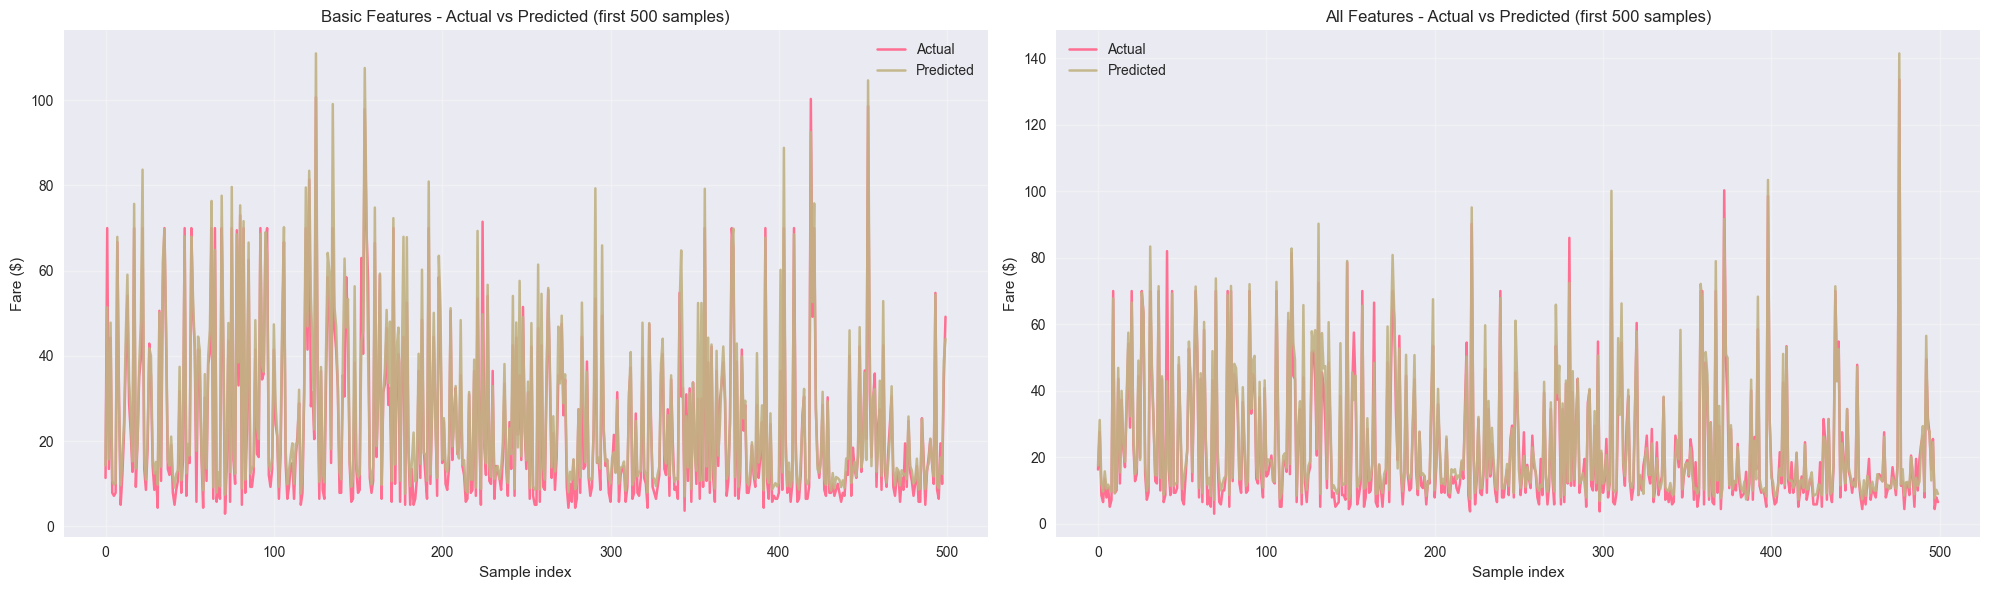

In [58]:
# Vẽ biểu đồ so sánh kết quả dự đoán và thực tế (Visualization)
print("Creating comparison plots...")

# Sample data for visualization
N = 500 #Có thể tùy chỉnh (modifiable)
pred_pdf = (
    lr_predictions.select("fare_amount", "prediction")
    .limit(N).toPandas()
    .rename(columns={"fare_amount": "actual", "prediction": "pred"})
)

pred_pdf_all = (
    lr_predictions_all.select("fare_amount", "prediction")
    .limit(N).toPandas()
    .rename(columns={"fare_amount": "actual", "prediction": "pred"})
)

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Basic features plot
ax1.plot(pred_pdf.index, pred_pdf["actual"], label="Actual", color="#ff6f91", linewidth=1.8)
ax1.plot(pred_pdf.index, pred_pdf["pred"], label="Predicted", color="#c0b283", linewidth=1.8, alpha=0.9)
ax1.set_title(f"Basic Features - Actual vs Predicted (first {N} samples)")
ax1.set_xlabel("Sample index")
ax1.set_ylabel("Fare ($)")
ax1.legend()
ax1.grid(alpha=0.3)

# All features plot
ax2.plot(pred_pdf_all.index, pred_pdf_all["actual"], label="Actual", color="#ff6f91", linewidth=1.8)
ax2.plot(pred_pdf_all.index, pred_pdf_all["pred"], label="Predicted", color="#c0b283", linewidth=1.8, alpha=0.9)
ax2.set_title(f"All Features - Actual vs Predicted (first {N} samples)")
ax2.set_xlabel("Sample index")
ax2.set_ylabel("Fare ($)")
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()